# Baseline Model

Goal: Predict the number of attendees for a MLB game based on the past average attendance for the home team and the away team at specific stadiums.

In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test_with_starttime.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_train_with_starttime.csv')

In [3]:
# shape of the data
print(raw_test_df.shape)
print(raw_train_df.shape)

raw_train_df.head() # 過去

(2445, 25)
(12270, 25)


,attendance,start_time,day,month,is_federal_holiday,venue,at_night,on_grass,temperature,wind_speed,...,team1_pre_win_pct,team1_players,team1_streak,team2_name,team2_pre_win,team2_pre_loss,team2_pre_win_pct,team2_players,team2_streak,start_hour
0,35055,2015-04-05 19:17:00,Sunday,April,0,Wrigley Field,True,True,44,7,...,0.0,Batting AB R H RBI BB SO ...,0,ChicagoCubs,0,0,0.0,Batting AB R H RBI ...,0,19
1,49043,2015-04-06 19:13:00,Monday,April,0,Chase Field,True,True,81,7,...,0.0,Batting AB R H RBI BB SO P...,0,ArizonaDiamondbacks,0,0,0.0,Batting AB R H RBI BB ...,0,19
2,43633,2015-04-06 16:10:00,Monday,April,0,Great American Ball Park,False,True,68,15,...,0.0,Batting AB R H RBI BB SO PA...,0,CincinnatiReds,0,0,0.0,Batting AB R H RBI BB SO P...,0,16
3,45030,2015-04-06 13:08:00,Monday,April,0,Comerica Park,False,True,52,5,...,0.0,Batting AB R H RBI BB SO P...,0,DetroitTigers,0,0,0.0,Batting AB R H RBI BB SO PA ...,0,13
4,43753,2015-04-06 18:10:00,Monday,April,0,Minute Maid Park,True,True,79,14,...,0.0,Batting AB R H RBI BB SO PA...,0,HoustonAstros,0,0,0.0,Batting AB R H RBI BB SO PA ...,0,18


In [4]:
raw_test_df.columns[:20], raw_train_df.columns[:20]

(Index(['attendance', 'start_time', 'day', 'month', 'is_federal_holiday',
        'venue', 'at_night', 'on_grass', 'temperature', 'wind_speed', 'weather',
        'precipitation', 'team1_name', 'team1_pre_win', 'team1_pre_loss',
        'team1_pre_win_pct', 'team1_players', 'team1_streak', 'team2_name',
        'team2_pre_win'],
       dtype='object'),
 Index(['attendance', 'start_time', 'day', 'month', 'is_federal_holiday',
        'venue', 'at_night', 'on_grass', 'temperature', 'wind_speed', 'weather',
        'precipitation', 'team1_name', 'team1_pre_win', 'team1_pre_loss',
        'team1_pre_win_pct', 'team1_players', 'team1_streak', 'team2_name',
        'team2_pre_win'],
       dtype='object'))

In [5]:
raw_train_df.iloc[:5, :10]

,attendance,start_time,day,month,is_federal_holiday,venue,at_night,on_grass,temperature,wind_speed
0,35055,2015-04-05 19:17:00,Sunday,April,0,Wrigley Field,True,True,44,7
1,49043,2015-04-06 19:13:00,Monday,April,0,Chase Field,True,True,81,7
2,43633,2015-04-06 16:10:00,Monday,April,0,Great American Ball Park,False,True,68,15
3,45030,2015-04-06 13:08:00,Monday,April,0,Comerica Park,False,True,52,5
4,43753,2015-04-06 18:10:00,Monday,April,0,Minute Maid Park,True,True,79,14


In [6]:
raw_test_df.start_time.min()

'2022-11-05 19:03:00'

## Preprocessing

Extract only needed features from the dataset. Combine training and test data to ensure that the same encoding is used for both.

In [6]:
processed_train_df = raw_train_df.copy()
processed_test_df = raw_test_df.copy()

processed_train_df['label'] = 0 # train data is labeled as 0
processed_test_df['label'] = 1 # test data is labeled as 1

processed_df = pd.concat([processed_train_df, processed_test_df], axis=0, ignore_index=True)

baseline_df = processed_df[['attendance', 'start_time', 'day', 'month', 'is_federal_holiday', 'venue', 'team1_name','team2_name', 'label']]

In [7]:
baseline_df.head()

,attendance,start_time,day,month,is_federal_holiday,venue,team1_name,team2_name,label
0,35055,2015-04-05 19:17:00,Sunday,April,0,Wrigley Field,StLouisCardinals,ChicagoCubs,0
1,49043,2015-04-06 19:13:00,Monday,April,0,Chase Field,SanFranciscoGiants,ArizonaDiamondbacks,0
2,43633,2015-04-06 16:10:00,Monday,April,0,Great American Ball Park,PittsburghPirates,CincinnatiReds,0
3,45030,2015-04-06 13:08:00,Monday,April,0,Comerica Park,MinnesotaTwins,DetroitTigers,0
4,43753,2015-04-06 18:10:00,Monday,April,0,Minute Maid Park,ClevelandIndians,HoustonAstros,0


## Cases

### Case 1: Use "Moving Average" as the baseline model

In [8]:
tmp_df = baseline_df.copy().sort_values('start_time').reset_index(drop=True)
display(tmp_df.head(3))

tmp_df['MA(5)'] = tmp_df.groupby('venue')['attendance'].transform(lambda x: x.rolling(5, 1).mean())
tmp_df['MA(10)'] = tmp_df.groupby('venue')['attendance'].transform(lambda x: x.rolling(10, 1).mean())
tmp_df['MA(20)'] = tmp_df.groupby('venue')['attendance'].transform(lambda x: x.rolling(20, 1).mean())
display(tmp_df.head(3))

,attendance,start_time,day,month,is_federal_holiday,venue,team1_name,team2_name,label
0,35055,2015-04-05 19:17:00,Sunday,April,0,Wrigley Field,StLouisCardinals,ChicagoCubs,0
1,45030,2015-04-06 13:08:00,Monday,April,0,Comerica Park,MinnesotaTwins,DetroitTigers,0
2,45909,2015-04-06 13:12:00,Monday,April,0,Safeco Field,LosAngelesAngelsofAnaheim,SeattleMariners,0


,attendance,start_time,day,month,is_federal_holiday,venue,team1_name,team2_name,label,MA(5),MA(10),MA(20)
0,35055,2015-04-05 19:17:00,Sunday,April,0,Wrigley Field,StLouisCardinals,ChicagoCubs,0,35055.0,35055.0,35055.0
1,45030,2015-04-06 13:08:00,Monday,April,0,Comerica Park,MinnesotaTwins,DetroitTigers,0,45030.0,45030.0,45030.0
2,45909,2015-04-06 13:12:00,Monday,April,0,Safeco Field,LosAngelesAngelsofAnaheim,SeattleMariners,0,45909.0,45909.0,45909.0


In [31]:
X_train = tmp_df[tmp_df['label'] == 0][['attendance', 'venue', 'label', 'start_time']].drop(['attendance', 'label'], axis=1)
y_train = tmp_df[tmp_df['label'] == 0]['attendance']
print(len(y_train))

X_test = tmp_df[tmp_df['label'] == 1][['attendance', 'venue', 'label', 'start_time']].drop(['attendance', 'label'], axis=1)
y_test = tmp_df[tmp_df['label'] == 1]['attendance']
print(len(y_test))

12270
2445


In [10]:
y_pred_5 = tmp_df[tmp_df['label'] == 1]['MA(5)']
y_pred_10 = tmp_df[tmp_df['label'] == 1]['MA(10)']
y_pred_20 = tmp_df[tmp_df['label'] == 1]['MA(20)']

In [48]:
# MSE, MAE, RMSE, R2, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# evalue metrics for regression model
def regression_metrics(y_true, y_pred, title:str = "", verbose:bool = True):
    if verbose:
        print(f"{'='*20} {title} {'='*20}")
        print('MSE: ', mean_squared_error(y_true, y_pred))
        print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_pred)))
        print('MAE: ', mean_absolute_error(y_true, y_pred))
        print('MAPE', mean_absolute_percentage_error(y_true, y_pred))
        print('R2: ', r2_score(y_true, y_pred))
    return {'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)), 'MAE': mean_absolute_error(y_true, y_pred), 'MAPE': mean_absolute_percentage_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}

_ = regression_metrics(y_test, y_pred_5, title='MA(5)')
_ = regression_metrics(y_test, y_pred_10, title='MA(10)')
_ = regression_metrics(y_test, y_pred_20, title='MA(20)')

==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
R2:  0.7534442029726554
==================== MA(10) ====================
MSE:  36100815.54388108
RMSE:  6008.395421731253
MAE:  4688.461536663745
MAPE 0.22495736353325774
R2:  0.7249642666440126
==================== MA(20) ====================
MSE:  40202889.010135874
RMSE:  6340.574817012719
MAE:  4984.3818591214895
MAPE 0.238388670382685
R2:  0.6937124301667961


In [12]:
venue_att_dict = dict.fromkeys(baseline_df['venue'].unique())
print(venue_att_dict)

{'Wrigley Field': None, 'Chase Field': None, 'Great American Ball Park': None, 'Comerica Park': None, 'Minute Maid Park': None, 'Kauffman Stadium': None, 'Dodger Stadium': None, 'Marlins Park': None, 'Miller Park': None, 'Yankee Stadium III': None, 'O.co Coliseum': None, 'Citizens Bank Park': None, 'Safeco Field': None, 'Tropicana Field': None, 'Nationals Park': None, 'Petco Park': None, 'Angel Stadium of Anaheim': None, 'Turner Field': None, 'Oriole Park at Camden Yards': None, 'U.S. Cellular Field': None, 'Progressive Field': None, 'Coors Field': None, 'Globe Life Park in Arlington': None, 'Fenway Park': None, 'Target Field': None, 'Citi Field': None, 'PNC Park': None, 'AT&T Park': None, 'Busch Stadium III': None, 'Rogers Centre': None, 'Oakland-Alameda County Coliseum': None, 'Fort Bragg Park': None, 'Guaranteed Rate Field': None, 'SunTrust Park': None, 'BB&T Park': None, 'Estadio Hiram Bithorn': None, 'Estadio de Beisbol Monterrey': None, 'Tokyo Dome': None, 'T-Mobile Park': None, 

In [13]:
unique_stadium = list(tmp_df['venue'].unique())

for venue in unique_stadium:
    try:
        ds_test_index = (X_test['venue'].str.contains(venue))
        tmp_y_test = y_test[ds_test_index].values
        tmp_y_pred_5 = y_pred_5[ds_test_index].values
        tmp_y_pred_10 = y_pred_10[ds_test_index].values
        tmp_y_pred_20 = y_pred_20[ds_test_index].values
        metric_dict = {}
        metric_dict['MA(5)'] = regression_metrics(tmp_y_test, tmp_y_pred_5, title=f'{venue} MA(5)', verbose=False)
        metric_dict['MA(10)'] = regression_metrics(tmp_y_test, tmp_y_pred_10, title=f'{venue} MA(10)', verbose=False)
        metric_dict['MA(20)'] = regression_metrics(tmp_y_test, tmp_y_pred_20, title=f'{venue} MA(20)', verbose=False)
        
        venue_att_dict[venue] = metric_dict
    except:
        pass

    if venue == 'Yankee Stadium III':
        print(venue)
        print(venue_att_dict[venue]['MA(5)'])
        print(venue_att_dict[venue]['MA(10)'])
        print(venue_att_dict[venue]['MA(20)'])

Yankee Stadium III
{'RMSE': 4589.100225429397, 'MAE': 3529.0554216867467, 'R2': 0.3918695205775182}
{'RMSE': 5152.147523202667, 'MAE': 3816.287951807229, 'R2': 0.23348922371942182}
{'RMSE': 5345.151044999142, 'MAE': 4151.660240963855, 'R2': 0.17498537077140153}


/Users/brian/.local/share/virtualenvs/SLDL-MLB-ATT-Prediction-gFjMjB_x/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/brian/.local/share/virtualenvs/SLDL-MLB-ATT-Prediction-gFjMjB_x/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/brian/.local/share/virtualenvs/SLDL-MLB-ATT-Prediction-gFjMjB_x/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/brian/.local/share/virtualenvs/SLDL-MLB-ATT-Prediction-gFjMjB_x/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two sample

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# matplotlib style ggplot
plt.style.use('ggplot')

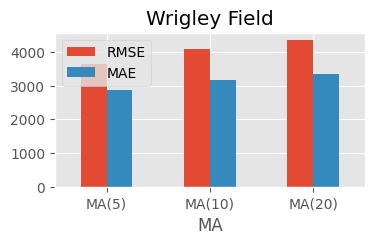

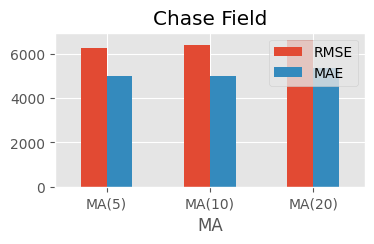

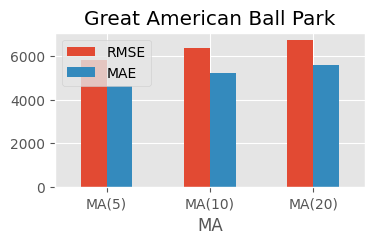

In [15]:
for venue in list(venue_att_dict.keys())[:3]:
    if venue_att_dict[venue] is None:
        continue
    # plot MSE, MAE, RMSE against MA(5), MA(10), MA(20) for each stadium using bar plot with seaborn
    tmp_venue_df = pd.DataFrame(venue_att_dict[venue]).T.reset_index().rename(columns={'index': 'MA'}).drop('R2', axis=1)
    tmp_venue_df.plot(kind='bar', x="MA", figsize=(4, 2), title=venue, rot=0)

In [16]:
# use 10 MA as the baseline, we want to see the performance of each stadium
ma_10_dict = venue_att_dict.copy()
for venue in ma_10_dict.keys():
    if ma_10_dict[venue] is None:
        continue
    ma_10_dict[venue] = ma_10_dict[venue]['MA(10)']

In [17]:
ma_10_df = pd.DataFrame(ma_10_dict).T.reset_index().rename(columns={'index': 'venue'}).dropna()
ma_10_df.head()

,venue,RMSE,MAE,R2
0,Wrigley Field,4072.916731,3151.81358,-0.003118
1,Chase Field,6402.025788,5003.808642,-0.07674
2,Great American Ball Park,6349.239174,5194.5,0.131343
3,Comerica Park,5866.832847,4265.595,0.198048
4,Minute Maid Park,4788.396544,3944.709091,0.050125


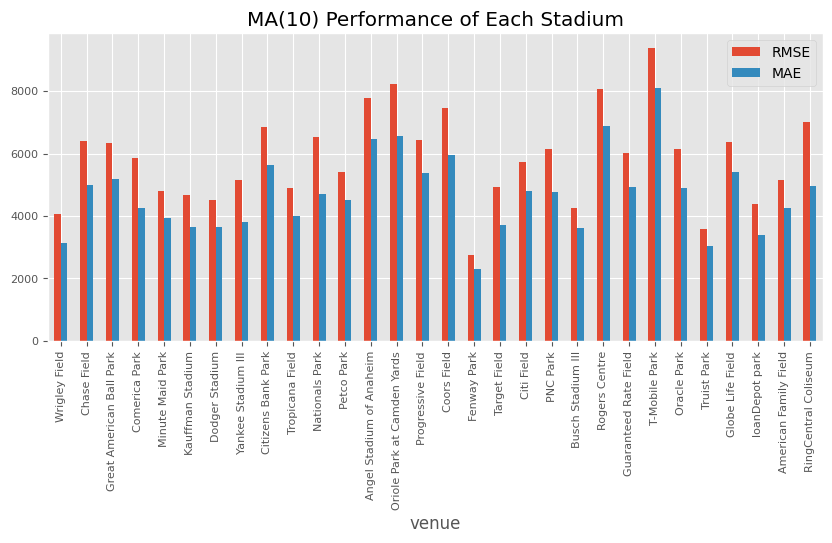

In [18]:
# plot the performance of each stadium
# grouped bar chart

fig, ax = plt.subplots(figsize=(10, 4))
# smaller font size
ma_10_df.drop('R2', axis=1).plot(kind='bar', x='venue', ax=ax, rot=90, title='MA(10) Performance of Each Stadium', fontsize=8)
plt.show()

In [19]:
# plot trainig data vs. predicted data
# plot only for Dodger Stadium
ds_index = tmp_df['venue'].str.contains('Dodger Stadium')
ds_train_index = (X_train['venue'].str.contains('Dodger Stadium'))
ds_test_index = (X_test['venue'].str.contains('Dodger Stadium'))

In [20]:
ds_index.sum(), ds_train_index.sum(), ds_test_index.sum()

(516, 433, 83)

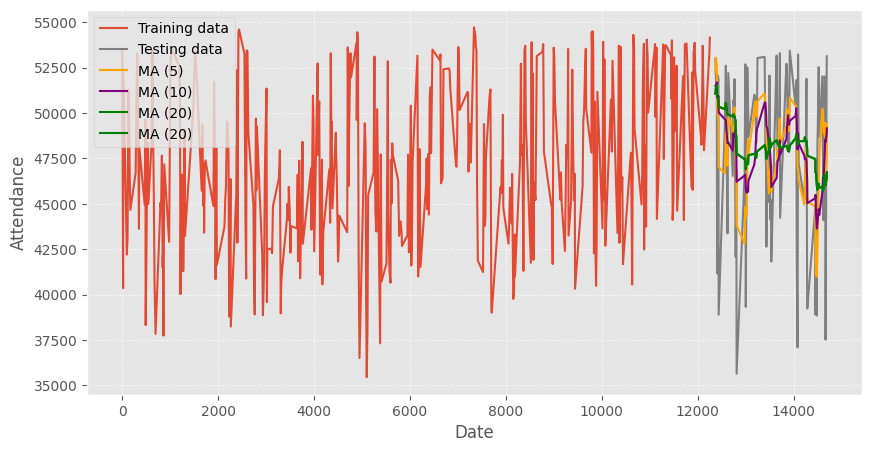

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(y_train[ds_train_index], label='Training data')
plt.plot(y_test[ds_test_index], color='gray', label='Testing data')
plt.plot(y_pred_5[ds_test_index], color='orange', label='MA (5)')
plt.plot(y_pred_10[ds_test_index], color='purple', label='MA (10)')
plt.plot(y_pred_20[ds_test_index], color='green', label='MA (20)')
plt.plot(y_pred_20[ds_test_index], color='green', label='MA (20)')
plt.ylabel('Attendance')
plt.xlabel('Date')
plt.grid(linestyle=':')
# plt.fill_between(y_pred.index, 0, y_pred, color='orange', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# group prediction data into a dataframe

y_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred_5': y_pred_5, 'y_pred_10': y_pred_10, 'y_pred_20': y_pred_20})
y_pred_df.to_csv('baseline.csv', index=False)

### Case 2: Use "Average" as the baseline model

In [32]:
# average attendance of each stadium

tmp_train_df = tmp_df[tmp_df['label'] == 0]
avg_map_df = pd.DataFrame(tmp_train_df.groupby('venue')['attendance'].mean().sort_values(ascending=False))
avg_map_df.head()

,attendance
venue,
London Stadium,59359.000000
Dodger Stadium,47389.468822
Tokyo Dome,46119.000000
Busch Stadium III,42755.568293
Yankee Stadium III,40792.543269


In [40]:
y_pred_avg_only = []
for row in X_test.iterrows():
    if row[1]['venue'] in avg_map_df.index:
        y_pred_avg_only.append(avg_map_df.loc[row[1]['venue'], 'attendance'])
    elif row[1]['venue'] == 'Truist Park':
        y_pred_avg_only.append(avg_map_df.loc['SunTrust Park', 'attendance'])
    else:
        y_pred_avg_only.append(avg_map_df['attendance'].mean())

In [49]:
_ = regression_metrics(y_test, y_pred_avg_only, title='Average Attendance Only', verbose=True)

==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
R2:  0.322810033729782


In [47]:
# group prediction data into a dataframe

y_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred_5': y_pred_5, 'y_pred_10': y_pred_10, 'y_pred_20': y_pred_20, 'y_pred_avg_only': y_pred_avg_only})
y_pred_df.to_csv('baseline.csv', index=False)